In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import lda_utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Import Dataset and LDA Model Inputs

In [35]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
wallstreet.columns

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['postID', 'threadID', 'threadTitle', 'subforum', 'authorName',
       'postAuthorMembership', 'authorReputation', 'postSequence',
       'contentWithHTMLTag', 'post_date_dt', 'author_join_date',
       'num_days_member_when_posted', 'wordcloud_text', 'cleaned_text',
       'lemmatized_tokens', 'processed_text'],
      dtype='object')

In [23]:
n_topics = 20
max_doc_freq = 0.7
max_features = 10000
max_iterations = 25

lemmatized_tokens = wallstreet['processed_text']

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
lemmatized_tokens[:10]

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    ['thought', 'would', 'introduce', 'new', 'comm...
1                   ['hello', 'nice', 'see', 'regard']
2    ['hello', 'everyone', 'would', 'like', 'tell',...
3    ['hello', 'punka', 'nice', 'meet', 'asked', 's...
4    ['changelog', 'wednesday', 'november', 'lot', ...
5    ['changelog', 'saturday', 'november', 'recoded...
6    ['changelog', 'tuesday', 'november', 'becoming...
7                                          ['welcome']
8    ['changelog', 'saturday', 'november', 'vendor'...
9    ['ability', 'migrate', 'listing', 'hansa', 'ma...
Name: processed_text, dtype: object

--- 
# Bag of Words

In [25]:
# Must be even for visualizations.

lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = lda_utils.convert_to_bow_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
lda_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
like wrote know would people make good one think time

Topic #1:
card credit visa bank cc debit state gift mastercard cvv

Topic #2:
mirror use onionshop euro per flight und travel ghb hotel

Topic #3:
order utopia refund reship xa0 kush gramo customer btc quality

Topic #4:
drug consider ice arab sand nun smashed testicle eskimo interested

Topic #5:
guide bank cashout record pack ssn extra link offer fraud

Topic #6:
pgp signature begin message end signed hash vendor name version

Topic #7:
note bill test quality paper counterfeit euro mg one pas

Topic #8:
account bank drop paypal transfer need wrote card btc money

Topic #9:
file use click password go key user using open tail

Topic #10:
market wrote need pm contact vendor send link looking shop

Topic #11:
method guide fullz money need cashout offer new check make

Topic #12:
rule help wsm phished contact external allowed please wrote link

Topic #13:
good know thanks work dont code see keep long dude

Topic #14:
order 

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


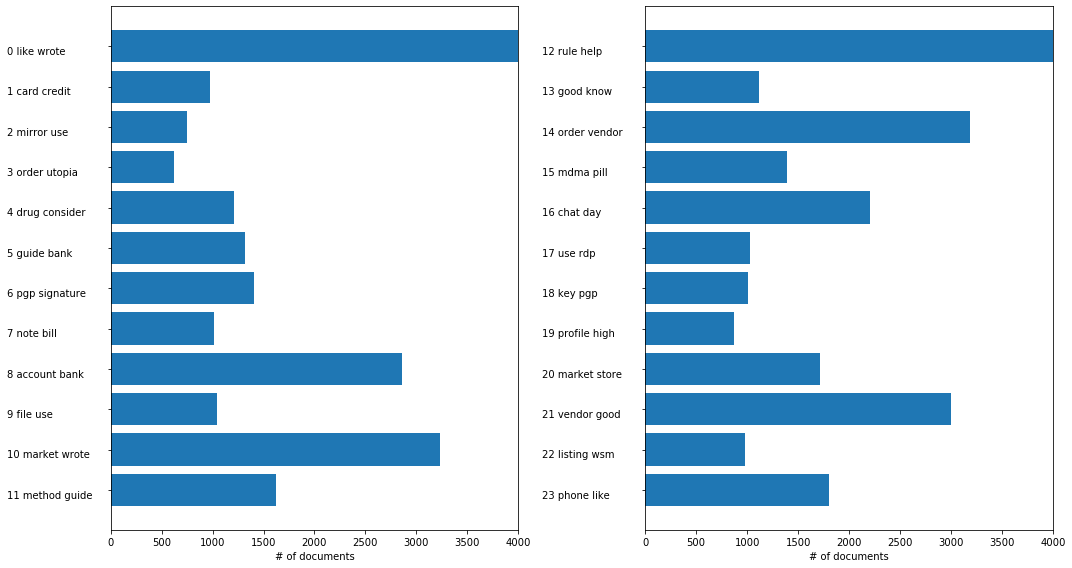

In [27]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 4000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [28]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.158991  0.126160       1        1  15.034748
14     0.112475  0.061304       2        1   7.377444
23     0.090313  0.177112       3        1   7.123762
21    -0.023677  0.061352       4        1   6.146181
8      0.085298 -0.005968       5        1   5.766198
5      0.015924 -0.033521       6        1   5.445346
12     0.112206 -0.244882       7        1   4.922917
10     0.091010 -0.137997       8        1   4.029084
16     0.157601  0.021192       9        1   4.020968
11     0.009291  0.053589      10        1   3.781234
24    -0.165793  0.091042      11        1   3.501765
9      0.135889  0.084982      12        1   3.500796
7     -0.054654  0.201104      13        1   3.337126
17     0.082626  0.113797      14        1   3.284750
3     -0.206972 -0.026371      15        1   2.922065
15    -0.184234  0.011130      16        1   2.852397
1     -0.144043 -0.068080      17        1   2.565152
20    -0.016760  0.032229      18        1   2.557872
6      0.033871 -0.285653      19        1   2.103901
4      0.022972  0.039430      20        1   1.869893
22    -0.098452 -0.023098      21        1   1.723777
18     0.106271 -0.185303      22        1   1.614309
19    -0.257380 -0.051114      23        1   1.534304
2     -0.145418 -0.009935      24        1   1.499976
13     0.082644 -0.002502      25        1   1.484033, topic_info=      Term          Freq         Total Category  logprob  loglift
1287  card   8682.000000   8682.000000  Default  30.0000  30.0000
7584  rule   7291.000000   7291.000000  Default  29.0000  29.0000
731   bank  12197.000000  12197.000000  Default  28.0000  28.0000
9862   wsm  10702.000000  10702.000000  Default  27.0000  27.0000
6453   pgp   5532.000000   5532.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
7771   see    651.689673   4456.301619  Topic25  -3.5928   2.2879
6077    ok    221.425359    973.737554  Topic25  -4.6723   2.7294
5026   let    316.073493   2995.643956  Topic25  -4.3164   1.9615
5220  luck    170.345748   1022.229281  Topic25  -4.9346   2.4185
8024  site    142.396682   2301.743058  Topic25  -5.1138   1.4276

[1815 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         6  0.921523       __
1         6  0.078718      ___
1         9  0.016286      ___
1        11  0.097718      ___
1        13  0.029858      ___
...     ...       ...      ...
9994     22  0.954956      для
9995     22  0.947868  игровые
9996     22  0.909609   казино
9997     22  0.938756       на
9999     22  0.933149   онлайн

[6295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 15, 24, 22, 9, 6, 13, 11, 17, 12, 25, 10, 8, 18, 4, 16, 2, 21, 7, 5, 23, 19, 20, 3, 14])

### Model Performance

In [29]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -11090057.134995624
Perplexity:  1090.0779039967392
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


```
Log Likelihood:  -10370297.725188904
Perplexity:  1092.0654064934693
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
```

---
# TF-IDF

In [30]:
def calculate_tfidf_and_fit_lda_model(docs_raw, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        docs_raw (arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vectorizer = TfidfVectorizer(max_features=max_feats, max_df=freq_thresh)
    docs_vectorized = vectorizer.fit_transform(docs_raw)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    lda_output = lda_model.fit_transform(docs_vectorized)
    
    return lda_output, lda_model, docs_vectorized, vectorizer

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = lda_utils.calculate_tfidf_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, 
                                                                                                                   n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
lda_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)


Topic #0:
order vendor dispute wrote italian time day know would escrow

Topic #1:
deal become marketplace unfree rebellion existence act online absolutely world

Topic #2:
mirror onionshop use visit shop ready mdma mastercardslink offfers listing

Topic #3:
utopia refund xa0 order reship gramo gr kush europe following

Topic #4:
arab sand nun ice smashed testicle eskimo consider drug interested

Topic #5:
guide cashout bank record ssn pack extra offer link sale

Topic #6:
pgp signature begin message end signed moved hash phished wsm

Topic #7:
good like note would vendor quality time know review product

Topic #8:
account drop bank card transfer paypal looking need cash fund

Topic #9:
pm market jabber icepapi name wrote send message interested find

Topic #10:
added listing und ich hq wochris spam profil report fresh

Topic #11:
ok hacker service hacking marketplace done number job best hack

Topic #12:
external contact allowed rule link please read offsite trade account

Topic #13:

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.096101  0.100307       1        1  14.810880
14     0.129442  0.017080       2        1  12.748581
0      0.140940  0.039058       3        1  11.953180
16     0.183835  0.054579       4        1   7.959646
8      0.181814  0.043568       5        1   6.080286
23     0.166702  0.036502       6        1   5.219124
24    -0.063230  0.106410       7        1   4.544647
17     0.051358 -0.267626       8        1   4.340380
5      0.082746  0.046005       9        1   3.560521
12     0.037838 -0.253626      10        1   2.924043
6     -0.072513 -0.262793      11        1   2.472158
4      0.046074  0.048389      12        1   2.233570
21     0.019737  0.009201      13        1   2.158111
9      0.076055 -0.053085      14        1   2.101619
22    -0.083105  0.053307      15        1   1.922822
2     -0.081257  0.046596      16        1   1.919859
1      0.052125 -0.033939      17        1   1.827323
20    -0.250151 -0.115462      18        1   1.631582
11    -0.018489  0.029532      19        1   1.525058
18     0.023330  0.041952      20        1   1.442835
19    -0.211006  0.104043      21        1   1.358655
15    -0.165023  0.014577      22        1   1.355226
10    -0.088891  0.028413      23        1   1.340717
13    -0.083670  0.040335      24        1   1.322169
3     -0.170763  0.126677      25        1   1.247006, topic_info=          Term         Freq        Total Category  logprob  loglift
1169      bump   828.000000   828.000000  Default  30.0000  30.0000
9862       wsm  1448.000000  1448.000000  Default  29.0000  29.0000
8383     store   763.000000   763.000000  Default  28.0000  28.0000
6453       pgp   684.000000   684.000000  Default  27.0000  27.0000
7584      rule  1083.000000  1083.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
6755     price    13.643859   331.109997  Topic25  -5.1890   1.1953
2076  customer    12.217938   231.317044  Topic25  -5.2994   1.4435
6991   quality    12.104157   377.786363  Topic25  -5.3087   0.9436
1136       btc    11.589782   264.776687  Topic25  -5.3521   1.2557
8942       top    11.232343   165.683949  Topic25  -5.3835   1.6931

[1652 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
8         1  0.178327     ab
8         2  0.082305     ab
8         3  0.082305     ab
8         4  0.521263     ab
8         6  0.013717     ab
...     ...       ...    ...
9961      2  0.949545    yup
9969      4  0.159273  zelle
9969      6  0.796365  zelle
9977     25  0.743233  zloty
9981     23  0.886539     zu

[6601 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 15, 1, 17, 9, 24, 25, 18, 6, 13, 7, 5, 22, 10, 23, 3, 2, 21, 12, 19, 20, 16, 11, 14, 4])

In [34]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -1665512.34
Perplexity:  7681.7
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


```
Log Likelihood:  -1624973.12
Perplexity:  7314.36
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
```